In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
cmap_kentech_blue = mcolors.LinearSegmentedColormap.from_list(
    "custom_cmap", 
    [(0.0, (0, 0, 0, 0)),
     (0, "#001334"),
     (1.0, "#007BC7")],
    N=256
)
cmap_kentech_blue.set_bad(color=(0, 0, 0, 0))
cmap_kentech_blue.set_under("#001334")
cmap_kentech_blue.set_over("#007BC7")

In [2]:
path_pnnl_inputs = Path.cwd() / "data" / "inputs" / "pnnl" 
path_pnnl_outputs = Path.cwd() / "data" / "outputs" / "pnnl"

technology_all = ["Lithium-ion_LFP", "Lithium-ion_NMC", "Lead_Acid", "Vanadium_Redox_Flow", "Zinc"]
year_all = [2023, 2030]
estimate_all = ["Point", "High", "Low"]

count_months = pd.read_csv(path_pnnl_outputs / f"{technology_all[0]}_{year_all[0]}_{estimate_all[0]}.csv").to_numpy().shape[1]
count_years = int(count_months / 12) # these two are identical for all techyearestimate because the same full SMP is used

In [3]:
def get_nars_yearly_all_configs(technology: str, year: int, estimate: str):
    estimate_read_filename = "Point" if technology != "Zinc" else estimate
    nars_monthly_all_configs = pd.read_csv(path_pnnl_outputs / f"{technology}_{year}_{estimate_read_filename}.csv").to_numpy()
    count_configs, count_months = nars_monthly_all_configs.shape

    idx_month_grouped_by_years = [list(range(count_months))[12 * idx_year: 12 * (idx_year + 1)] for idx_year in range(int(count_months / 12))] # helper grouped month idx list
    nars_yearly_all_configs = np.empty((count_configs, int(count_months / 12)), dtype=float) # count_config x count_years initialization
    nars_monthly_all_configs = np.nan_to_num(nars_monthly_all_configs, nan=0) # nan -> 0
    nars_monthly_all_configs[nars_monthly_all_configs < 0] = 0 # negative -> 0

    for idx_config, nars_single_config_all_months in enumerate(nars_monthly_all_configs):
        for idx_year, idx_month_grouped_by_year in enumerate(idx_month_grouped_by_years):
            nars_yearly_all_configs[idx_config, idx_year] = nars_single_config_all_months[idx_month_grouped_by_year].sum() # 12 months -> 1 year

    return nars_yearly_all_configs

In [4]:
dict_params_all_chems, dict_nars_yearly_all_chems = dict(), dict()

for technology in technology_all:
    for year in year_all:
        for estimate in estimate_all:
            techyearestimate = f"{technology}_{year}_{estimate}"
            dict_params_all_chems[techyearestimate] = pd.read_csv(path_pnnl_inputs / f"{technology}_{year}_{estimate}.csv").to_numpy()
            dict_nars_yearly_all_chems[techyearestimate] = get_nars_yearly_all_configs(technology, year, estimate)

In [5]:
dict_operating_profits_yearly_all_chems = dict()

for (techyearestimate, params_all_configs), (nars_yearly_all_configs) in zip(dict_params_all_chems.items(), dict_nars_yearly_all_chems.values()):
    opexes_yearly_all_configs = params_all_configs[:, 6][:, None]
    dict_operating_profits_yearly_all_chems[techyearestimate] = nars_yearly_all_configs - np.tile(opexes_yearly_all_configs, (1, count_years))

In [6]:
dict_payback_periods_yearly_all_chems = dict()

for (techyearestimate, params_all_configs), operating_profits_yearly_all_configs in zip(dict_params_all_chems.items(), dict_operating_profits_yearly_all_chems.values()):
    capexes_all_configs = params_all_configs[:, 7][:, None]
    dict_payback_periods_yearly_all_chems[techyearestimate] = np.tile(capexes_all_configs, (1, count_years))  / operating_profits_yearly_all_configs

---
---
---
---
---
---

In [7]:
##############################################################################
# CUSTOM EFFICIENCY
##############################################################################

NAR_by_efficiency = dict()


for delta_efficiency, number in zip(["m2", "m1", "p1", "p2"], [-0.02, -0.01, 0.01, 0.02]):
    NAR_by_efficiency[number] = pd.read_csv(path_pnnl_outputs / delta_efficiency / "Lithium-ion_LFP_2023_Point.csv").sum(axis=1).to_numpy()[[12, 14, 15, 16]][:, None]
    if number == -0.01:
        NAR_by_efficiency[0] = dict_nars_yearly_all_chems["Lithium-ion_LFP_2023_Point"][:, -1][[12, 14, 15, 16]][:, None]

In [8]:
NAR_by_efficiency

{-0.02: array([[1.89561728e+09],
        [3.21768181e+09],
        [4.13713226e+09],
        [4.66280643e+09]]),
 -0.01: array([[2.05520841e+09],
        [3.51855862e+09],
        [4.55640696e+09],
        [5.16550466e+09]]),
 0: array([[2.21750466e+09],
        [3.82617769e+09],
        [4.98997478e+09],
        [5.68972345e+09]]),
 0.01: array([[2.38189274e+09],
        [4.13881113e+09],
        [5.43325272e+09],
        [6.22826752e+09]]),
 0.02: array([[2.55028196e+09],
        [4.45807810e+09],
        [5.88643994e+09],
        [6.78143860e+09]])}

In [9]:
capex_2023_Point = dict_params_all_chems["Lithium-ion_LFP_2023_Point"][[12, 14, 15, 16], -1][:, None]
opex_2023_Point = dict_params_all_chems["Lithium-ion_LFP_2023_Point"][[12, 14, 15, 16], -2][:, None]
capex_2030_Low = dict_params_all_chems["Lithium-ion_LFP_2030_Low"][[12, 14, 15, 16], -1][:, None]
opex_2030_Low = dict_params_all_chems["Lithium-ion_LFP_2030_Low"][[12, 14, 15, 16], -2][:, None]
capex_2030_Point = dict_params_all_chems["Lithium-ion_LFP_2030_Point"][[12, 14, 15, 16], -1][:, None]
opex_2030_Point = dict_params_all_chems["Lithium-ion_LFP_2030_Point"][[12, 14, 15, 16], -2][:, None]
capex_2030_High = dict_params_all_chems["Lithium-ion_LFP_2030_High"][[12, 14, 15, 16], -1][:, None]
opex_2030_High = dict_params_all_chems["Lithium-ion_LFP_2030_High"][[12, 14, 15, 16], -2][:, None]

In [10]:
prof_2023_Point_by_efficiency = dict()
for key, val in NAR_by_efficiency.items():
    prof_2023_Point_by_efficiency[key] = val - opex_2023_Point

prof_2030_Low_by_efficiency = dict()
for key, val in NAR_by_efficiency.items():
    prof_2030_Low_by_efficiency[key] = val  - opex_2030_Low

prof_2030_Point_by_efficiency = dict()
for key, val in NAR_by_efficiency.items():
    prof_2030_Point_by_efficiency[key] = val  - opex_2030_Point

prof_2030_High_by_efficiency = dict()
for key, val in NAR_by_efficiency.items():
    prof_2030_High_by_efficiency[key] = val  - opex_2030_High

In [ ]:
prof_2030_Low_by_efficiency[-0.02]

{-0.02: array([[1.63568228e+09],
        [2.78312381e+09],
        [3.53195026e+09],
        [3.88566743e+09]]),
 -0.01: array([[1.79527341e+09],
        [3.08400062e+09],
        [3.95122496e+09],
        [4.38836566e+09]]),
 0: array([[1.95756966e+09],
        [3.39161969e+09],
        [4.38479278e+09],
        [4.91258445e+09]]),
 0.01: array([[2.12195774e+09],
        [3.70425313e+09],
        [4.82807072e+09],
        [5.45112852e+09]]),
 0.02: array([[2.29034696e+09],
        [4.02352010e+09],
        [5.28125794e+09],
        [6.00429960e+09]])}

In [11]:
paybackperiod_2023_Point_by_efficiency = dict()
for key, val in prof_2023_Point_by_efficiency.items():
    paybackperiod_2023_Point_by_efficiency[key] = capex_2023_Point / val

paybackperiod_2030_Low_by_efficiency = dict()
for key, val in prof_2030_Low_by_efficiency.items():
    paybackperiod_2030_Low_by_efficiency[key] = capex_2030_Low / val

paybackperiod_2030_Point_by_efficiency = dict()
for key, val in prof_2030_Point_by_efficiency.items():
    paybackperiod_2030_Point_by_efficiency[key] = capex_2030_Point / val

paybackperiod_2030_High_by_efficiency = dict()
for key, val in prof_2030_High_by_efficiency.items():
    paybackperiod_2030_High_by_efficiency[key] = capex_2030_High / val

In [12]:
ccf_2023_Point_by_efficiency = dict()
for key, val in prof_2023_Point_by_efficiency.items():
    capex_matrix = np.tile(-capex_2023_Point, (1, 101))
    year_factors = np.arange(101)[None, :]
    cumulative_profits = val * year_factors
    ccf_2023_Point_by_efficiency[key] = capex_matrix + cumulative_profits

ccf_2030_Low_by_efficiency = dict()
for key, val in prof_2030_Low_by_efficiency.items():
    capex_matrix = np.tile(-capex_2030_Low, (1, 101))
    year_factors = np.arange(101)[None, :]
    cumulative_profits = val * year_factors
    ccf_2030_Low_by_efficiency[key] = capex_matrix + cumulative_profits

ccf_2030_Point_by_efficiency = dict()
for key, val in prof_2030_Point_by_efficiency.items():
    capex_matrix = np.tile(-capex_2030_Point, (1, 101))
    year_factors = np.arange(101)[None, :]
    cumulative_profits = val * year_factors
    ccf_2030_Point_by_efficiency[key] = capex_matrix + cumulative_profits

ccf_2030_High_by_efficiency = dict()
for key, val in prof_2030_High_by_efficiency.items():
    capex_matrix = np.tile(-capex_2030_High, (1, 101))
    year_factors = np.arange(101)[None, :]
    cumulative_profits = val * year_factors
    ccf_2030_High_by_efficiency[key] = capex_matrix + cumulative_profits

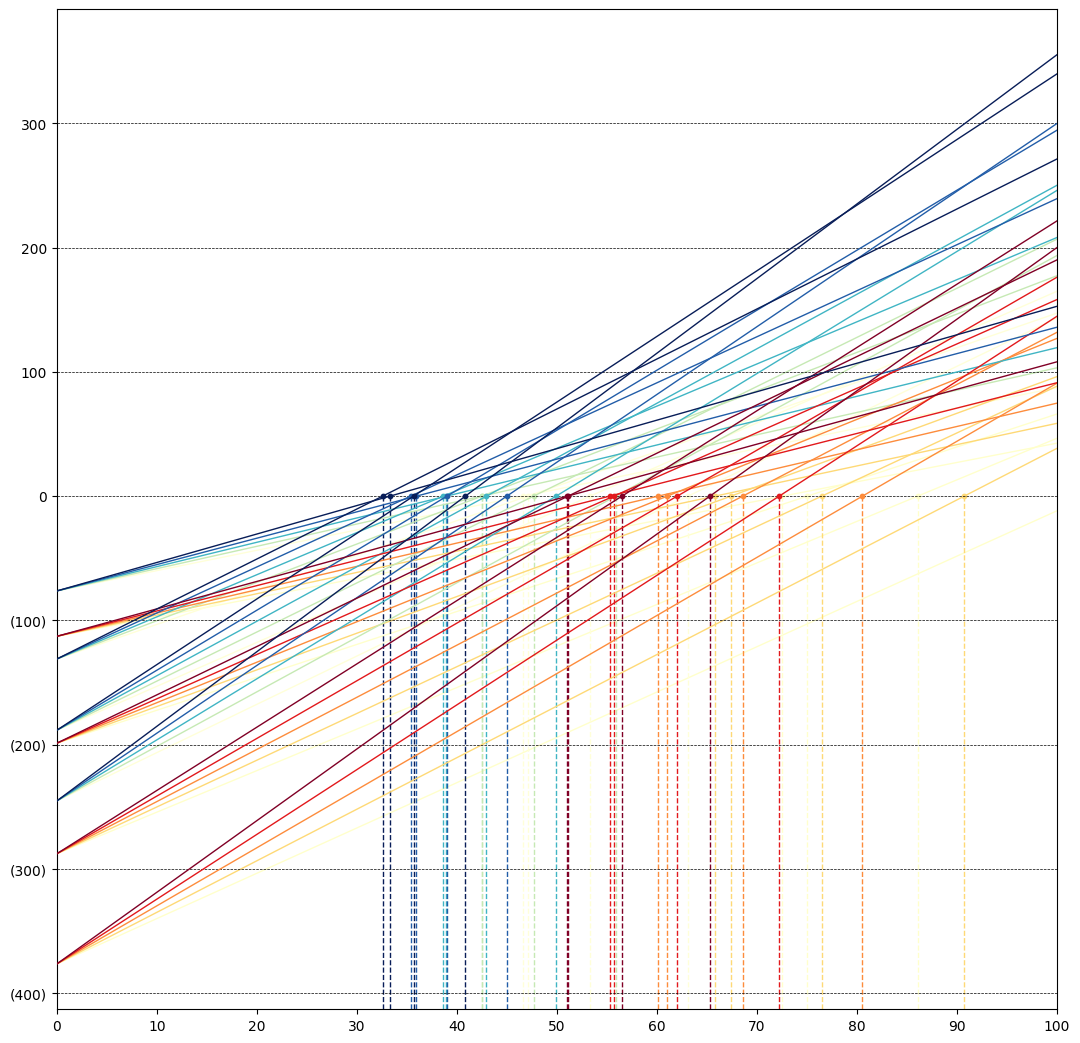

In [68]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0, 0, 1, 1])

for idx, arr in enumerate([ccf_2023_Point_by_efficiency.values(), ccf_2030_Low_by_efficiency.values()]):
    for idx_config, val in enumerate(arr):
        ax.plot(
            range(0, 101), 
            val.transpose() / 1e9,
            color=[
                plt.colormaps["YlOrRd"](np.linspace(0, 1, 5)), 
                plt.colormaps["YlGnBu"](np.linspace(0, 1, 5))
            ][idx][idx_config],
            zorder=idx_config, 
            linewidth=1,
        )

for idx, arr in enumerate([paybackperiod_2023_Point_by_efficiency.values(), paybackperiod_2030_Low_by_efficiency.values()]):
    for idx_config, val in enumerate(arr):
        ax.scatter(
            val,
            [0] * 4, 
            color=[
                plt.colormaps["YlOrRd"](np.linspace(0, 1, 5)), 
                plt.colormaps["YlGnBu"](np.linspace(0, 1, 5))
            ][idx][idx_config],
            zorder=idx_config, 
            s=10,
        )





########################### ax lim
ax.set_xlim(0, 100)
ax.set_xticks(range(0, 101, 10))
############################ y lim is kieep , (negative) manipulation
ax_current_ylim = ax.get_ylim()
yticks = ax.get_yticks()
ax.set_yticks(yticks)
ytick_labels = [f"({abs(val):.0f})" if val < 0 else f"{val:.0f}" for val in yticks]
ax.set_yticklabels(ytick_labels)
ax.set_ylim(ax_current_ylim)
# ################################################################ THINGS THAT USE YLIM
for idx, arr in enumerate([paybackperiod_2023_Point_by_efficiency.values(), paybackperiod_2030_Low_by_efficiency.values()]):
    for idx_config, val in enumerate(arr):
        ax.vlines(
            val,
            ymin=ax.get_ylim()[0],
            ymax=0,
            color=[
                plt.colormaps["YlOrRd"](np.linspace(0, 1, 5)), 
                plt.colormaps["YlGnBu"](np.linspace(0, 1, 5))
            ][idx][idx_config],
            zorder=0, 
            linewidth=1,
            linestyle="--",
        )



ax.grid(True, which="major", axis="y", zorder=0, alpha=1, linewidth=.5,color="black", linestyle="--",)


---
---
---

In [13]:
dict_payback_periods_2022_all_chems = dict()
dict_payback_periods_2023_all_chems = dict()
dict_payback_periods_2024_all_chems = dict()

for (techyearestimate, payback_periods_yearly_all_configs) in dict_payback_periods_yearly_all_chems.items():
    dict_payback_periods_2022_all_chems[techyearestimate] = payback_periods_yearly_all_configs[:, -3]
    dict_payback_periods_2023_all_chems[techyearestimate] = payback_periods_yearly_all_configs[:, -2]
    dict_payback_periods_2024_all_chems[techyearestimate] = payback_periods_yearly_all_configs[:, -1]

In [14]:
dict_payback_periods_min_2024_by_year_by_estimate = dict()

for year in year_all:
    for estimate in estimate_all:

        payback_periods_argmin_techyearestimate, payback_periods_argmin_config, payback_periods_min = None, None, 1e10

        for (techyearestimate, payback_periods_2024_all_configs) in dict_payback_periods_2024_all_chems.items():        
            if (int(techyearestimate.split("_")[-2]), str(techyearestimate.split("_")[-1])) != (year, estimate):
                continue

            candidate_min = float(np.abs(payback_periods_2024_all_configs).min())
            if payback_periods_min > candidate_min:
                payback_periods_min = candidate_min
                payback_periods_argmin_techyearestimate = techyearestimate
                payback_periods_argmin_config = int(np.abs(payback_periods_2024_all_configs).argmin())
        
        dict_payback_periods_min_2024_by_year_by_estimate[f"{year}_{estimate}"] = (
            payback_periods_argmin_techyearestimate, payback_periods_argmin_config, payback_periods_min
        )

In [15]:
dict_payback_periods_min_2024_by_year_by_estimate

{'2023_Point': ('Lithium-ion_LFP_2023_Point', 12, 60.105387148842745),
 '2023_High': ('Lithium-ion_LFP_2023_High', 12, 67.31067821184934),
 '2023_Low': ('Lithium-ion_LFP_2023_Low', 12, 53.11241209158717),
 '2030_Point': ('Lithium-ion_LFP_2030_Point', 14, 42.04942511377778),
 '2030_High': ('Lithium-ion_LFP_2030_High', 14, 48.695733701731605),
 '2030_Low': ('Lithium-ion_LFP_2030_Low', 14, 35.09362737636369)}

---
---
---

In [16]:
from parallel_pnnl import get_all_months_smp

In [17]:
system_marginal_prices_grouped_by_month, count_months = get_all_months_smp("historical")
idx_month_grouped_by_years = [list(range(count_months))[12 * idx_year: 12 * (idx_year + 1)] for idx_year in range(int(count_months / 12))]
count_years = len(idx_month_grouped_by_years)
smp_sd_monthly = np.array([np.std(system_marginal_prices_by_month) for system_marginal_prices_by_month in  system_marginal_prices_grouped_by_month])
smp_sd_monthly_year_average = smp_sd_monthly.reshape(-1, 12).mean(axis=1)

---
---
---

In [18]:
technology = "Lithium-ion_LFP"
year = 2023
estimate = "Point"


techyearestimate = f"{technology}_{year}_{estimate}"
params_all_configs = dict_params_all_chems[techyearestimate]
target_nars_yearly_all_configs = dict_nars_yearly_all_chems[techyearestimate]
target_operating_profits_yearly_all_configs = dict_operating_profits_yearly_all_chems[techyearestimate]

count_configs = target_nars_yearly_all_configs.shape[0]
cappwr_per_config = [(pair[0], pair[1]) for pair in (dict_params_all_chems[techyearestimate][:, :2] / 1000).astype(int).tolist()]

arr_idx_config_cap = np.vstack((range(count_configs), dict_params_all_chems[techyearestimate][:, 0])).transpose().astype(int)
unique_cap = np.unique(arr_idx_config_cap[:, 1])
cmap_values_per_unique_cap = cmap_kentech_blue(np.linspace(0, 1, len(unique_cap)))
color_per_config = cmap_values_per_unique_cap[np.array([int(np.where(unique_cap == arr_idx_config_cap[idx_config][1])[0][0]) for idx_config in range(count_configs)])]

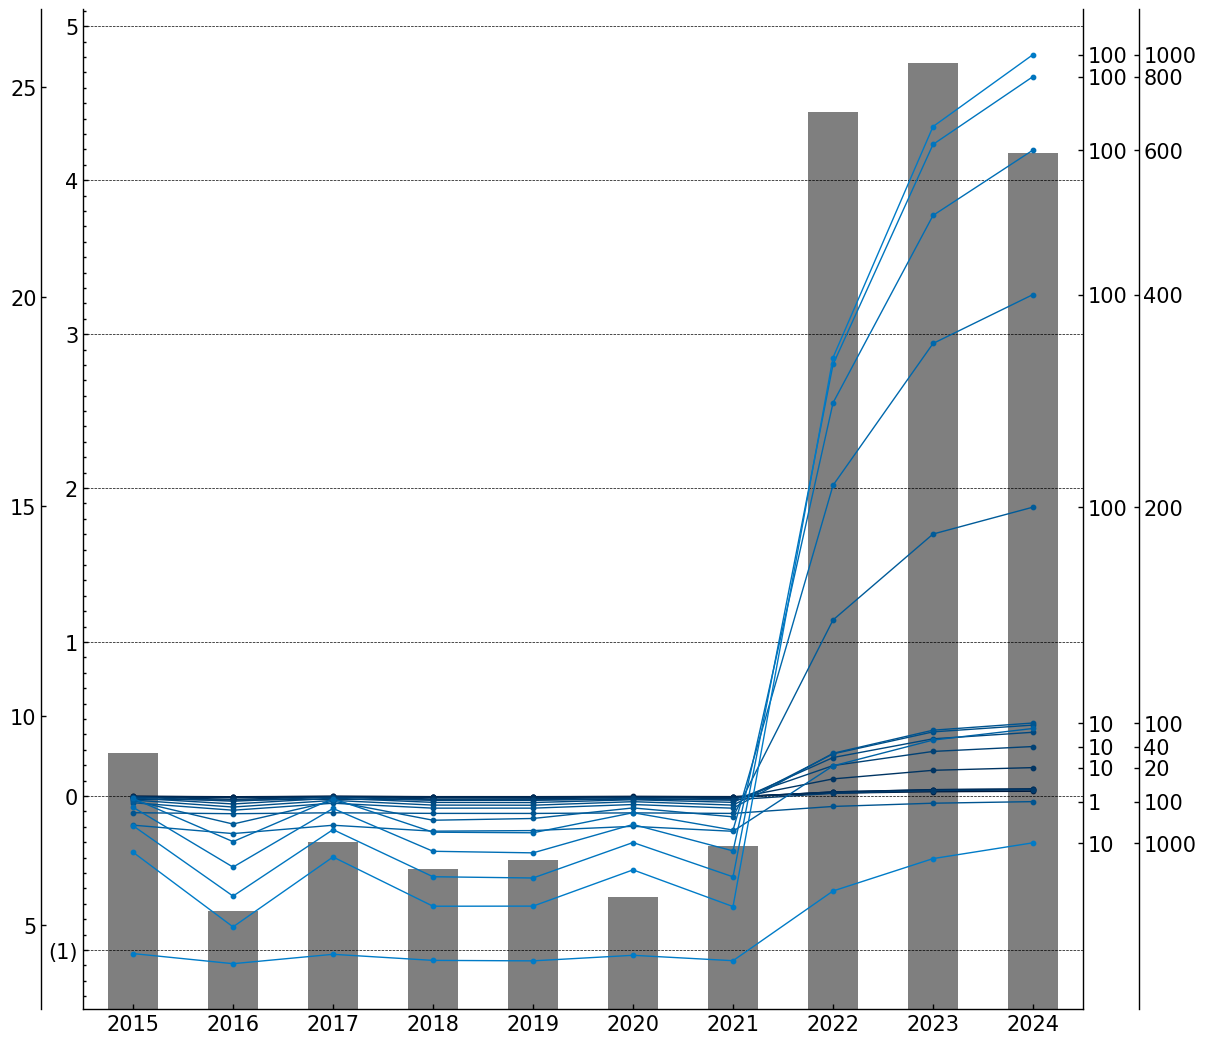

In [19]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0, 0, 1, 1])


axtx = ax.twinx()

ax.bar(
    range(2015, 2025), 
    smp_sd_monthly_year_average,
    linewidth=1,
    facecolor="black",
    alpha=.5,
    width=.5,
)

ax.set_ylim(3)
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("outward", 30))

###################operating profit
for idx_config, target_operating_profits_yearly in enumerate(target_operating_profits_yearly_all_configs):
    axtx.scatter(
        range(2015, 2025), 
        target_operating_profits_yearly / 1e9, 
        color=color_per_config[idx_config], 
        zorder=idx_config,
        s=10,
    )
    axtx.plot(
        range(2015, 2025), 
        target_operating_profits_yearly / 1e9, 
        color=color_per_config[idx_config], 
        zorder=idx_config,
        linewidth=1,
    )

axtx.yaxis.set_ticks_position("left")

ax.set_xticks(range(2015, 2025))
ax.set_xlim(2014.5, 2024.5)


# ax.legend()
axtx2 = axtx.twinx()
axtx3 = axtx.twinx()

axtx3.spines["right"].set_position(("outward", 40))

axtx2.set_ylim(np.array(axtx.get_ylim()) * 1e9)
axtx3.set_ylim(np.array(axtx.get_ylim()) * 1e9)

axtx23_ticks = np.sort(target_operating_profits_yearly_all_configs[:, -1])[[0, 1, 8, 9, -6, -5, -4, -3, -2, -1]]
axtx2.set_yticks(axtx23_ticks)
axtx3.set_yticks(axtx23_ticks)

sorted_indices = np.argsort(target_operating_profits_yearly_all_configs[:, -1])[[0, 1, 8, 9, -6, -5, -4, -3, -2, -1]]
axtx2.set_yticklabels([cappwr_per_config[i][1] for i in sorted_indices])
axtx3.set_yticklabels([cappwr_per_config[i][0] for i in sorted_indices])

for ax_ in [ax, axtx, axtx2, axtx3]:
    ax_.set_position([0, 0, 1, 1]) 
    ax_.tick_params(axis="both", direction="in", labelsize=15)
    ax_.tick_params(axis='both', width=1)
    for spine in ax_.spines.values():
        spine.set_linewidth(1)


axtx.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
axtx.tick_params(axis="y", which="minor", width=1, length=2, label1On=False, direction="in")



ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

axtx.spines["top"].set_visible(False)
axtx.spines["bottom"].set_visible(False)
axtx.spines["right"].set_visible(False)

axtx2.spines["top"].set_visible(False)
axtx2.spines["bottom"].set_visible(False)
axtx2.spines["left"].set_visible(False)


axtx3.spines["top"].set_visible(False)
axtx3.spines["bottom"].set_visible(False)
axtx3.spines["left"].set_visible(False)

axtx.grid(True, which="major", axis="y", zorder=0, alpha=1, linewidth=.5,color="black", linestyle="--",)


############## (negative)
axtx_current_ylim = axtx.get_ylim()

yticks = axtx.get_yticks()
axtx.set_yticks(yticks)
ytick_labels = [f"({abs(val):.0f})" if val < 0 else f"{val:.0f}" for val in yticks]
axtx.set_yticklabels(ytick_labels)

axtx.set_ylim(axtx_current_ylim)

plt.savefig("0.png", dpi=600, transparent=True, bbox_inches="tight", pad_inches=0)
# plt.show(fig)

---
---
---

In [20]:
dict_operating_profits_2024_all_chems = dict()

for key, value in dict_operating_profits_yearly_all_chems.items():
    dict_operating_profits_2024_all_chems[key] = value[:, -1]

minus_operating_profits_per_config_2024_all_chems = dict()

for key, values in dict_operating_profits_2024_all_chems.items():
    minus_op_idx_configs = []
    for idx_config, value in enumerate(values):
        if value < 0:
            minus_op_idx_configs.append(idx_config)
                    
    minus_operating_profits_per_config_2024_all_chems[key] = np.array(minus_op_idx_configs)

In [21]:
dict_rolling_payback_2024_all_chems = {}

for techyearestimate, params_all_configs in dict_params_all_chems.items():
    capex = -params_all_configs[:, 7] 
    capex_matrix = np.tile(capex[:, None], (1, 101))  

    op_profit_2024 = dict_operating_profits_2024_all_chems[techyearestimate]  
    year_factors = np.arange(101)[None, :]
    cumulative_profits = op_profit_2024[:, None] * year_factors
    rolling_payback = capex_matrix + cumulative_profits 
    dict_rolling_payback_2024_all_chems[techyearestimate] = rolling_payback

In [22]:
technology = "Lithium-ion_LFP"
year = 2023
estimate = "Point"

techyearestimate = f"{technology}_{year}_{estimate}"
params_all_configs = dict_params_all_chems[techyearestimate]
target_nars_yearly_all_configs = dict_nars_yearly_all_chems[techyearestimate]
target_operating_profits_yearly_all_configs = dict_operating_profits_yearly_all_chems[techyearestimate]
########
target_rolling_payback_2024_all_configs = dict_rolling_payback_2024_all_chems[techyearestimate]


count_configs = target_nars_yearly_all_configs.shape[0]
cappwr_per_config = [(pair[0], pair[1]) for pair in (dict_params_all_chems[techyearestimate][:, :2] / 1000).astype(int).tolist()]

arr_idx_config_cap = np.vstack((range(count_configs), dict_params_all_chems[techyearestimate][:, 0])).transpose().astype(int)
unique_cap = np.unique(arr_idx_config_cap[:, 1])
cmap_values_per_unique_cap = cmap_kentech_blue(np.linspace(0, 1, len(unique_cap)))
color_per_config = cmap_values_per_unique_cap[np.array([int(np.where(unique_cap == arr_idx_config_cap[idx_config][1])[0][0]) for idx_config in range(count_configs)])]

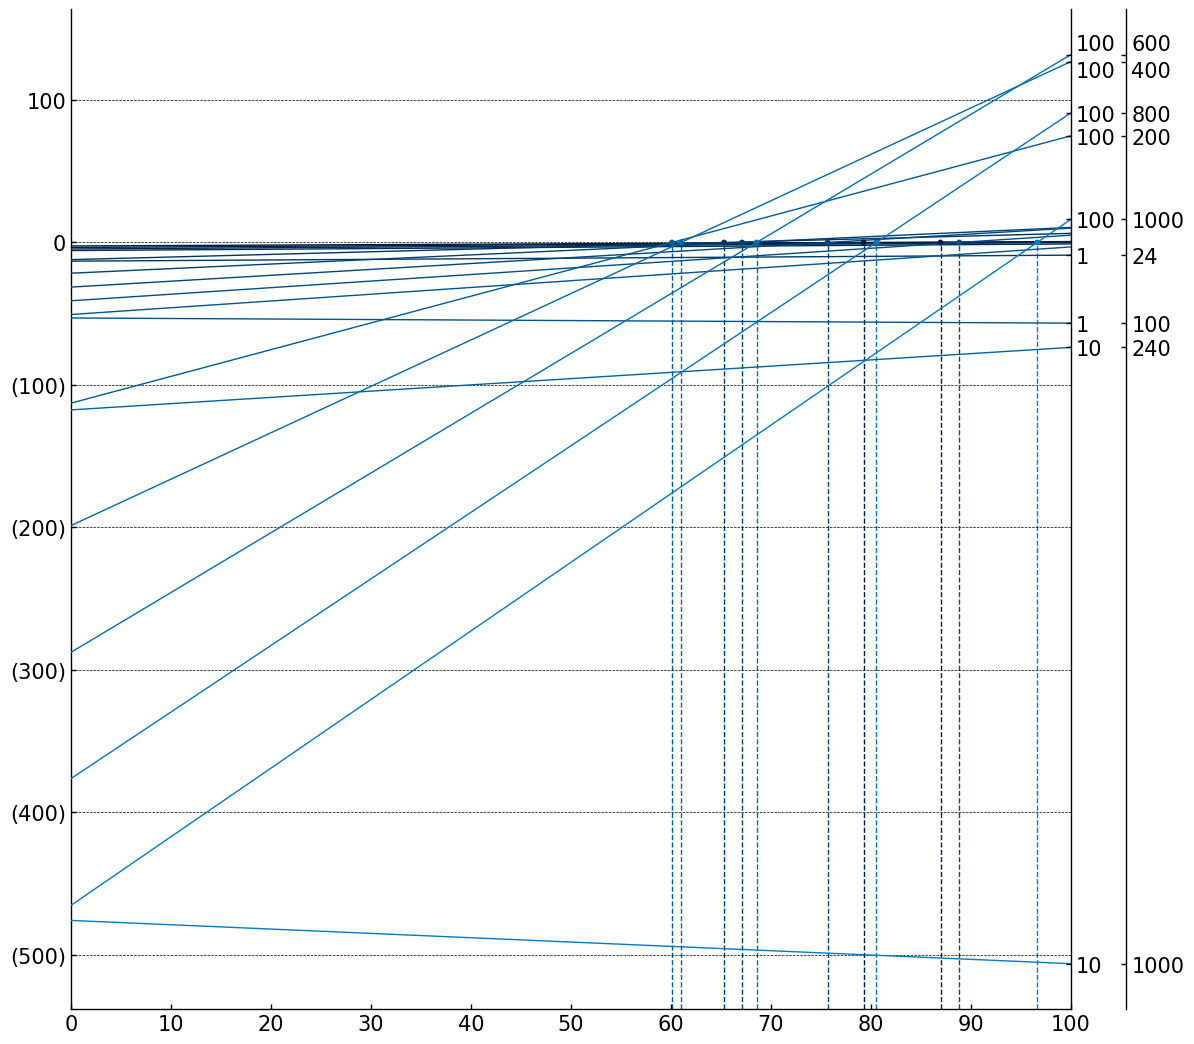

In [23]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0, 0, 1, 1])


for idx_config, target_rolling_payback_2024 in enumerate(target_rolling_payback_2024_all_configs):
    # if idx_config in minus_operating_profits_per_config_2024_all_chems[techyearestimate]:
    #     continue ################## skipping operaitng losses in 2024

    ax.plot(
        range(0, 101),
        target_rolling_payback_2024 / 1e9,
        color=color_per_config[idx_config],
        zorder=idx_config,
        linewidth=1,
    )   

ax.scatter(
    dict_payback_periods_2024_all_chems[techyearestimate],
    [0] * count_configs,
    color=color_per_config,
    zorder=idx_config,
    s=10,
)

########################### ax lim
ax.set_xlim(0, 100)
ax.set_xticks(range(0, 101, 10))
############################ y lim is kieep , (negative) manipulation
ax_current_ylim = ax.get_ylim()
yticks = ax.get_yticks()
ax.set_yticks(yticks)
ytick_labels = [f"({abs(val):.0f})" if val < 0 else f"{val:.0f}" for val in yticks]
ax.set_yticklabels(ytick_labels)
ax.set_ylim(ax_current_ylim)
################################################################ THINGS THAT USE YLIM
ax.vlines(
    dict_payback_periods_2024_all_chems[techyearestimate],
    ymin=ax.get_ylim()[0],
    ymax=0,
    linestyle="--",
    linewidth=1,
    # linewidth=np.array(list(range(19, 0, -1))) * 2,
    # colors="black",
    colors=color_per_config,
    zorder=0,
)
#################### legend axes
axtx2 = ax.twinx()
axtx3 = ax.twinx()
axtx3.spines["right"].set_position(("outward", 40))


final_vals = np.array([cfg[-1] for cfg in target_rolling_payback_2024_all_configs]) / 1e9
sorted_idx = np.argsort(final_vals)[[0, 1, 2, 3, 14, 15, 16, 17, 18]]
final_vals_sorted = final_vals[sorted_idx]

axtx2.set_ylim(ax.get_ylim())
axtx3.set_ylim(ax.get_ylim())
axtx2.set_yticks(final_vals_sorted)
axtx2.set_yticklabels([cappwr_per_config[i][1] for i in sorted_idx])
axtx3.set_yticks(final_vals_sorted)
axtx3.set_yticklabels([cappwr_per_config[i][0] for i in sorted_idx])

# Customize vertical alignment for last two tick labels
for axtx in [axtx2, axtx3]:
    labels = axtx.get_yticklabels()
    if len(labels) >= 2:
        labels[-1].set_verticalalignment('bottom')  
        labels[-2].set_verticalalignment('top')     

##################### ax basic setup + REMOVE DUPLICATE
for ax_ in [ax, axtx2, axtx3]:
    ax_.set_position([0, 0, 1, 1])
    ax_.tick_params(axis="both", direction="in", labelsize=15)
    ax_.tick_params(axis='both', width=1)
    for spine in ax_.spines.values():
        spine.set_linewidth(1)

    ax_.spines["top"].set_visible(False)
    if ax_ == ax:
        ax.spines["right"].set_visible(False)
    else:
        ax_.spines["bottom"].set_visible(False)
        ax_.spines["left"].set_visible(False)


########################################## grid
ax.grid(True, which="major", axis="y", zorder=0, alpha=1, linewidth=.5,color="black", linestyle="--",)
######################################### xaxis y = 0
# ax.spines["bottom"].set_position(("data", 0))
# ax.spines["left"].set_zorder(10)
# ax.xaxis.set_ticks_position("bottom")
# ax.yaxis.set_ticks_position("left")

######################### end
plt.savefig("1.png", dpi=600, transparent=True, bbox_inches="tight", pad_inches=0)
# plt.show(fig)


In [28]:
np.hstack((
    np.arange(19)[:, None], 
    (dict_params_all_chems["Lithium-ion_LFP_2023_Point"][:, [0, 1]] * .001).astype(int)
))

array([[   0,    2,    1],
       [   1,    4,    1],
       [   2,    6,    1],
       [   3,    8,    1],
       [   4,   10,    1],
       [   5,   20,   10],
       [   6,   24,    1],
       [   7,   40,   10],
       [   8,   60,   10],
       [   9,   80,   10],
       [  10,  100,    1],
       [  11,  100,   10],
       [  12,  200,  100],
       [  13,  240,   10],
       [  14,  400,  100],
       [  15,  600,  100],
       [  16,  800,  100],
       [  17, 1000,   10],
       [  18, 1000,  100]])

In [29]:
color_by_technology = {
    "Lithium-ion_LFP": "blue",
    "Lithium-ion_NMC": "green",
    "Vanadium_Redox_Flow": "red",
    "Lead_Acid": "yellow",
    "Zinc": "pink",
}

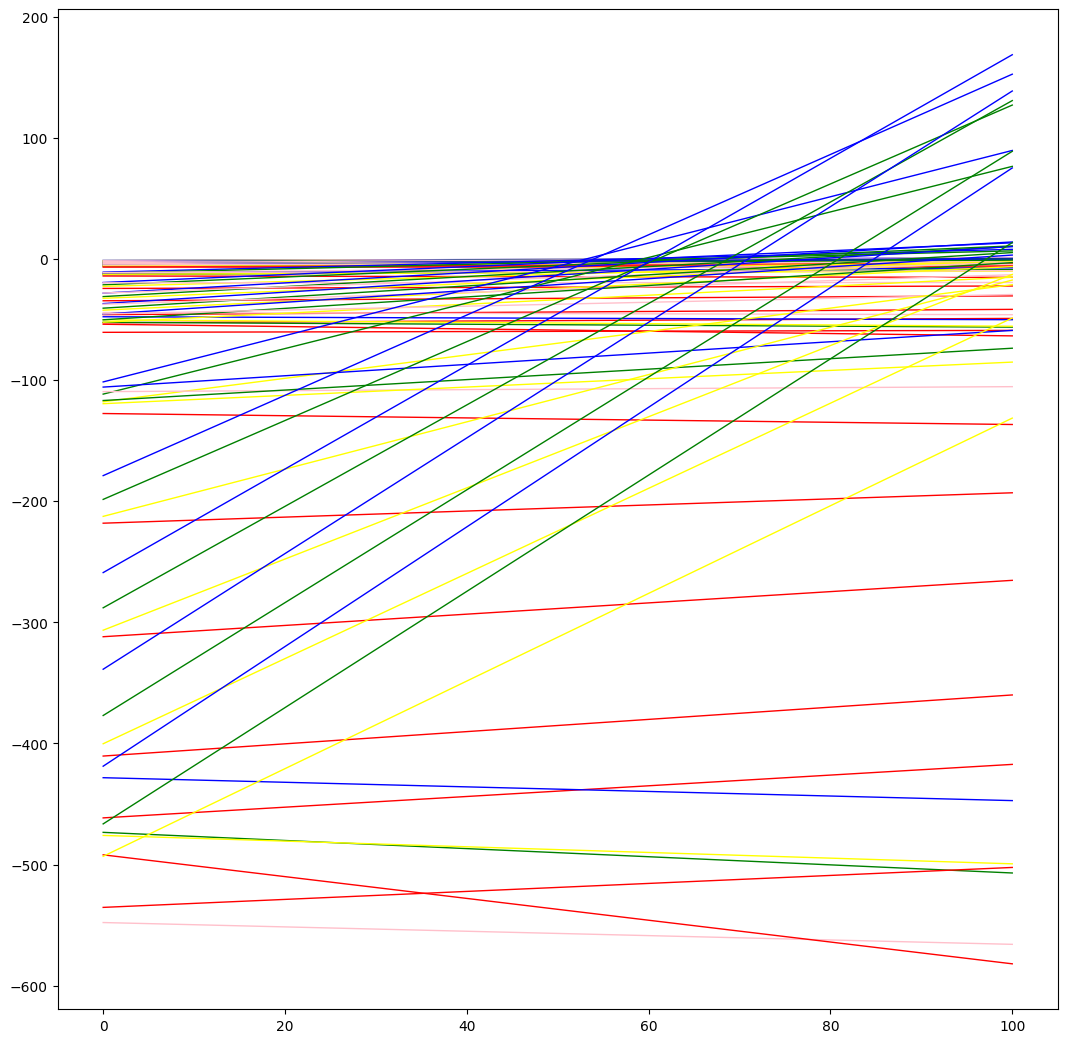

In [30]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0, 0, 1, 1])

for technology in technology_all:
    year = 2023
    estimate = "Low"

    techyearestimate = f"{technology}_{year}_{estimate}"
    params_all_configs = dict_params_all_chems[techyearestimate]
    target_nars_yearly_all_configs = dict_nars_yearly_all_chems[techyearestimate]
    target_operating_profits_yearly_all_configs = dict_operating_profits_yearly_all_chems[techyearestimate]
    ########
    target_rolling_payback_2024_all_configs = dict_rolling_payback_2024_all_chems[techyearestimate]


    count_configs = target_nars_yearly_all_configs.shape[0]
    cappwr_per_config = [(pair[0], pair[1]) for pair in (dict_params_all_chems[techyearestimate][:, :2] / 1000).astype(int).tolist()]

    arr_idx_config_cap = np.vstack((range(count_configs), dict_params_all_chems[techyearestimate][:, 0])).transpose().astype(int)
    unique_cap = np.unique(arr_idx_config_cap[:, 1])
    cmap_values_per_unique_cap = cmap_kentech_blue(np.linspace(0, 1, len(unique_cap)))
    color_per_config = cmap_values_per_unique_cap[np.array([int(np.where(unique_cap == arr_idx_config_cap[idx_config][1])[0][0]) for idx_config in range(count_configs)])]


    for idx_config, target_rolling_payback_2024 in enumerate(target_rolling_payback_2024_all_configs):
        # if idx_config in minus_operating_profits_per_config_2024_all_chems[techyearestimate]:
        #     continue ################## skipping operaitng losses in 2024

        ax.plot(
            range(0, 101),
            target_rolling_payback_2024 / 1e9,
            color=color_by_technology[technology],
            zorder=idx_config,
            linewidth=1,
        )   

    # ax.scatter(
    #     dict_payback_periods_2024_all_chems[techyearestimate],
    #     [0] * count_configs,
    #     color=color_per_config,
    #     zorder=idx_config,
    #     s=10,
    # )

# ########################### ax lim
# ax.set_xlim(0, 100)
# ax.set_xticks(range(0, 101, 10))
# ############################ y lim is kieep , (negative) manipulation
# ax_current_ylim = ax.get_ylim()
# yticks = ax.get_yticks()
# ax.set_yticks(yticks)
# ytick_labels = [f"({abs(val):.0f})" if val < 0 else f"{val:.0f}" for val in yticks]
# ax.set_yticklabels(ytick_labels)
# ax.set_ylim(ax_current_ylim)
# ################################################################ THINGS THAT USE YLIM
# ax.vlines(
#     dict_payback_periods_2024_all_chems[techyearestimate],
#     ymin=ax.get_ylim()[0],
#     ymax=0,
#     linestyle="--",
#     linewidth=1,
#     # linewidth=np.array(list(range(19, 0, -1))) * 2,
#     # colors="black",
#     colors=color_per_config,
#     zorder=0,
# )
# #################### legend axes
# axtx2 = ax.twinx()
# axtx3 = ax.twinx()
# axtx3.spines["right"].set_position(("outward", 40))


# final_vals = np.array([cfg[-1] for cfg in target_rolling_payback_2024_all_configs]) / 1e9
# sorted_idx = np.argsort(final_vals)[[0, 1, 2, 3, 14, 15, 16, 17, 18]]
# final_vals_sorted = final_vals[sorted_idx]

# axtx2.set_ylim(ax.get_ylim())
# axtx3.set_ylim(ax.get_ylim())
# axtx2.set_yticks(final_vals_sorted)
# axtx2.set_yticklabels([cappwr_per_config[i][1] for i in sorted_idx])
# axtx3.set_yticks(final_vals_sorted)
# axtx3.set_yticklabels([cappwr_per_config[i][0] for i in sorted_idx])


# ##################### ax basic setup + REMOVE DUPLICATE
# for ax_ in [ax, axtx2, axtx3]:
#     ax_.set_position([0, 0, 1, 1])
#     ax_.tick_params(axis="both", direction="in", labelsize=15)
#     ax_.tick_params(axis='both', width=1)
#     for spine in ax_.spines.values():
#         spine.set_linewidth(1)

#     ax_.spines["top"].set_visible(False)
#     if ax_ == ax:
#         ax.spines["right"].set_visible(False)
#     else:
#         ax_.spines["bottom"].set_visible(False)
#         ax_.spines["left"].set_visible(False)


# ########################################## grid
# ax.grid(True, which="major", axis="y", zorder=0, alpha=1, linewidth=.5,color="black", linestyle="--",)
######################### end
plt.show(fig)
# plt.savefig("0.png", dpi=600, transparent=True, bbox_inches="tight", pad_inches=0)


In [31]:
color_by_technology = { # POINT LOW HIGH / 2030 해도 기울기는 파랑 (LFP)가 가장 높음음  위 cell에서만만 수정해서 실행 가능 (y축 10억KRW)
    "Lithium-ion_LFP": "blue",
    "Lithium-ion_NMC": "green",
    "Vanadium_Redox_Flow": "red",
    "Lead_Acid": "yellow",
    "Zinc": "pink",
}

In [32]:
params_all_configs = dict_params_all_chems["Vanadium_Redox_Flow_2030_High"]
# duration vs rest # used in titling
np.vstack((params_all_configs[:, 0] / params_all_configs[:, 1], params_all_configs[:, 5])).transpose().astype(int)

array([[  2,   1],
       [  4,   0],
       [  6,   0],
       [  8,   0],
       [ 10,   0],
       [  2,   1],
       [ 24,   0],
       [  4,   0],
       [  6,   0],
       [  8,   0],
       [100,   0],
       [ 10,   0],
       [  2,   1],
       [ 24,   0],
       [  4,   0],
       [  6,   0],
       [  8,   0],
       [100,   0],
       [ 10,   0]])